In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset", shuffle=True, image_size  = (IMAGE_SIZE, IMAGE_SIZE), batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [7]:
classname = dataset.class_names
classname

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 2 1 1 0 1 1 0 0 0 0 0 1 1 2 0 2 1 1 1 0 0 0 1 1 0 0 1 0 0 1]


<h>Visualize some of the images from out dataset<h>

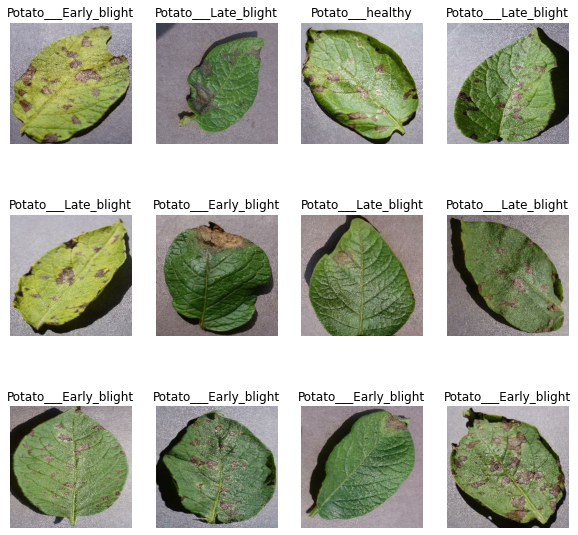

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classname[labels_batch[i]])
        plt.axis("off")

<b><h>Split the dataset<h><b>
1. Training
2. Validation
3. Testing

In [11]:
len(dataset)

68

In [14]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [15]:
train_ds = dataset.take(54)
len(train_ds)

54

In [16]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [17]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [18]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [23]:
train_split=0.8
val_split=0.1
test_split=0.1

assert train_split + val_split + test_split == 1

In [24]:
def get_dataset_paratitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert train_split + val_split + test_split == 1
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [25]:
train_ds, val_ds, test_ds = get_dataset_paratitions_tf(dataset)

In [26]:
len(train_ds)

54

In [27]:
len(val_ds)

6

In [28]:
len(test_ds)

8

Cache, Shuffle, and Prefetch the dataset

In [29]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Data Resizing & Normalization

In [30]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Data Augmentation

In [31]:
data_augmenation  = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [33]:
train_ds = train_ds.map(
lambda x, y : (data_augmenation(x, training=True), y)).prefetch(buffer_size = tf.data.AUTOTUNE)

Model Arc...

In [34]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(), 
    
    layers.Dense(64, activation='relu'),
    
    layers.Dense(n_classes, activation='softmax'),
    
])

model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [36]:
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics = ['accuracy'])

In [37]:
history = model.fit(
    train_ds,
    epochs = 10, 
    batch_size = BATCH_SIZE, 
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 [==============================] - 123s 2s/step - loss: 0.9104 - accuracy: 0.4821 - val_loss: 0.7924 - val_accuracy: 0.5312
Epoch 2/10
54/54 [==============================] - 97s 2s/step - loss: 0.7168 - accuracy: 0.6476 - val_loss: 0.6183 - val_accuracy: 0.6979
Epoch 3/10
54/54 [==============================] - 96s 2s/step - loss: 0.5402 - accuracy: 0.7465 - val_loss: 0.4211 - val_accuracy: 0.8021
Epoch 4/10
54/54 [==============================] - 96s 2s/step - loss: 0.4120 - accuracy: 0.8264 - val_loss: 0.5617 - val_accuracy: 0.7396
Epoch 5/10
54/54 [==============================] - 94s 2s/step - loss: 0.4165 - accuracy: 0.8160 - val_loss: 0.4091 - val_accuracy: 0.8229
Epoch 6/10
54/54 [==============================] - 95s 2s/step - loss: 0.3353 - accuracy: 0.8605 - val_loss: 0.2591 - val_accuracy: 0.8854
Epoch 7/10
54/54 [==============================] - 96s 2s/step - loss: 0.2622 - accuracy: 0.9057 - val_loss: 0.1855 - val_accuracy: 0.9271
Epoch 8/10
54/54 [=

In [38]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 510ms/step - loss: 0.2563 - accuracy: 0.9062


In [39]:
scores

[0.2563192844390869, 0.90625]

In [40]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [42]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [43]:
type(history.history['loss'])

list

In [44]:
len(history.history['loss'])

10

In [45]:
acc = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [47]:
val_acc

[0.53125,
 0.6979166865348816,
 0.8020833134651184,
 0.7395833134651184,
 0.8229166865348816,
 0.8854166865348816,
 0.9270833134651184,
 0.8645833134651184,
 0.921875,
 0.9479166865348816]

Visualize Loss & Accuarcy in Graph

Text(0.5, 1.0, 'Training & Validation Loss')

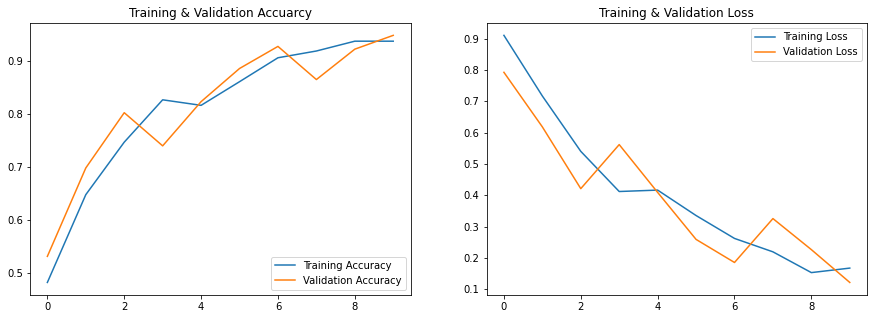

In [49]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label = "Training Accuracy")
plt.plot(range(10), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title('Training & Validation Accuarcy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label = "Training Loss")
plt.plot(range(10), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title('Training & Validation Loss')

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 879ms/step
predicted label: Potato___Late_blight


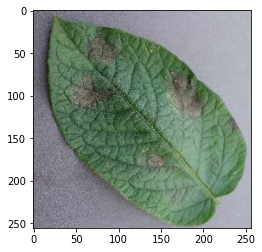

In [50]:
import numpy as np
for image_batch , labels_batch in test_ds.take(1):
    first_img = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_img)
    print('actual label:', classname[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('predicted label:', classname[np.argmax(batch_prediction[0])])

Homework to build a flask application for potato disease classification
and give ss on our discord server

In [55]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    
    predicted_class = classname[np.argmax(prediction[0])]
    confidence = round(100 * (np.argmax(prediction[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 73ms/step


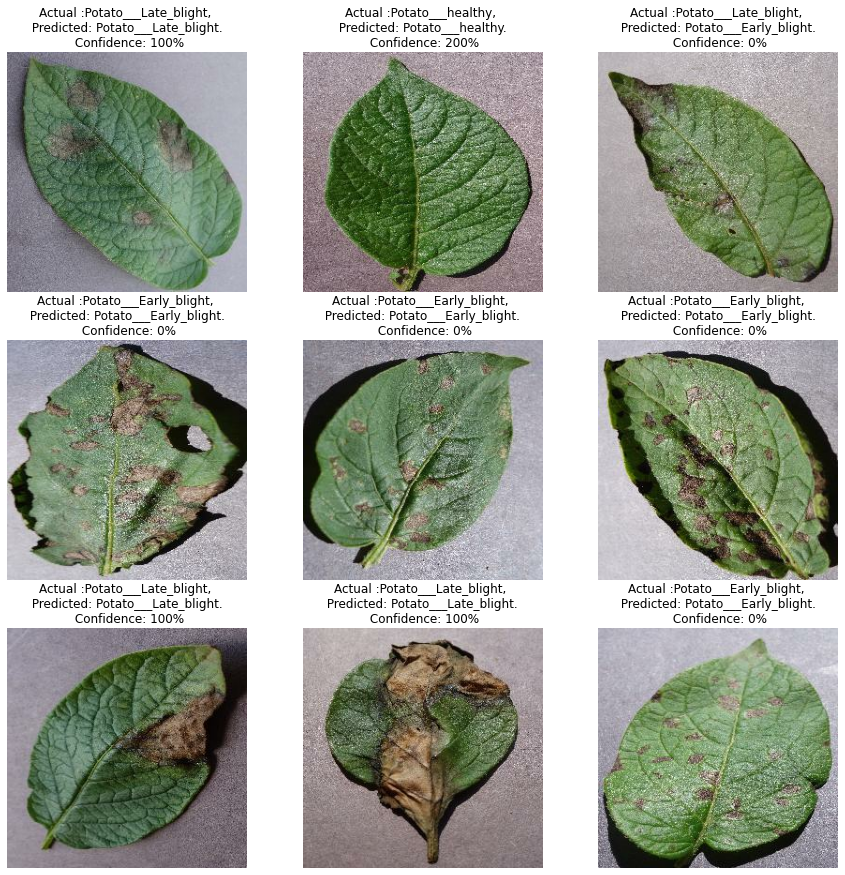

In [56]:
plt.figure(figsize = (15,15))

for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3 ,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i])
        actual_class = classname[labels[i]]
        
        plt.title(f"Actual :{actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        
        plt.axis("off")

Homework : gradio, streamlit, flask
    send the ss into our discord server